In [1]:
!pip install kagglehub tensorflow matplotlib numpy pandas scikit-learn

In [2]:
import kagglehub

# Download the APTOS 2019 dataset
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [3]:
import os

dataset_dir = '/kaggle/input/aptos2019'
print(os.listdir(dataset_dir))

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [4]:

print(os.getcwd())  # Print the current working directory


/kaggle/working


In [5]:
import os
import pandas as pd

# Define the new dataset directory
dataset_dir = '/kaggle/input/aptos2019'

# Load the CSV files
train_df = pd.read_csv(os.path.join(dataset_dir, 'train_1.csv'))
val_df = pd.read_csv(os.path.join(dataset_dir, 'valid.csv'))
test_df = pd.read_csv(os.path.join(dataset_dir, 'test.csv'))

# Map multiclass labels (0–4) to binary labels: 0 = No DR, 1 = DR
train_df['binary_label'] = train_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
val_df['binary_label'] = val_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
test_df['binary_label'] = test_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

# Update the path mapping for train, validation, and test datasets
train_df['id_code'] = train_df['id_code'].apply(lambda x: os.path.join('/kaggle/input/aptos2019/train_images/train_images', f'{x}.png'))
val_df['id_code'] = val_df['id_code'].apply(lambda x: os.path.join('/kaggle/input/aptos2019/val_images/val_images', f'{x}.png'))
test_df['id_code'] = test_df['id_code'].apply(lambda x: os.path.join('/kaggle/input/aptos2019/test_images/test_images', f'{x}.png'))

# Verify the changes
print("Training Data:")
print(train_df[['id_code', 'diagnosis', 'binary_label']].head())

print("\nValidation Data:")
print(val_df[['id_code', 'diagnosis', 'binary_label']].head())

print("\nTest Data:")
print(test_df[['id_code', 'diagnosis', 'binary_label']].head())


Training Data:
                                             id_code  diagnosis  binary_label
0  /kaggle/input/aptos2019/train_images/train_ima...          2             1
1  /kaggle/input/aptos2019/train_images/train_ima...          1             1
2  /kaggle/input/aptos2019/train_images/train_ima...          4             1
3  /kaggle/input/aptos2019/train_images/train_ima...          0             0
4  /kaggle/input/aptos2019/train_images/train_ima...          0             0

Validation Data:
                                             id_code  diagnosis  binary_label
0  /kaggle/input/aptos2019/val_images/val_images/...          2             1
1  /kaggle/input/aptos2019/val_images/val_images/...          4             1
2  /kaggle/input/aptos2019/val_images/val_images/...          1             1
3  /kaggle/input/aptos2019/val_images/val_images/...          0             0
4  /kaggle/input/aptos2019/val_images/val_images/...          0             0

Test Data:
                   

In [6]:
# Print the first few paths in 'id_code' to verify their correctness
print(train_df['id_code'].head())


0    /kaggle/input/aptos2019/train_images/train_ima...
1    /kaggle/input/aptos2019/train_images/train_ima...
2    /kaggle/input/aptos2019/train_images/train_ima...
3    /kaggle/input/aptos2019/train_images/train_ima...
4    /kaggle/input/aptos2019/train_images/train_ima...
Name: id_code, dtype: object


In [7]:
# Check if the images exist after updating paths
for img_path in train_df['id_code'].head():
    print(f"Path exists: {os.path.exists(img_path)}")


Path exists: True
Path exists: True
Path exists: True
Path exists: True
Path exists: True


In [8]:
!pip install opencv-python


In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

def preprocess_image(image_path, img_size=(224, 224)):
    """Applies CLAHE in the LAB color space, followed by Gaussian Blur, Resizing, and Normalization."""

    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split into L, A, B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel (Lightness)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge the CLAHE-enhanced L channel with the original A and B channels
    lab_clahe = cv2.merge((l_clahe, a, b))

    # Convert back to RGB
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # Apply Gaussian Blur (kernel size (5,5))
    img_blur = cv2.GaussianBlur(img_clahe, (5, 5), 0)

    # Resize to MobileNetV2 input size
    img_resized = cv2.resize(img_blur, img_size)

    # Normalize pixel values (0-1)
    img_normalized = img_resized / 255.0

    return img_normalized


In [11]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import numpy as np

class CustomDataGenerator(Sequence):
    """Custom data generator with minimal augmentation for binary classification."""

    def __init__(self, dataframe, batch_size=32, img_size=(224, 224), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()

        # Define MINIMAL augmentations to avoid distortion
        self.augmentation_layers = tf.keras.Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.005),
            RandomZoom(height_factor=(-0.03, 0), width_factor=(-0.03, 0))
        ])

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        """Generates a batch of images and labels."""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indexes]

        # Load and preprocess images
        images = np.array([preprocess_image(img_path) for img_path in batch_data['id_code']])
        labels = np.array(batch_data['binary_label'])  # <-- Modified line

        # Optional: reshape for sigmoid-compatible output
        labels = labels.reshape(-1, 1)

        # Apply data augmentation
        augmented_images = self.augmentation_layers(images, training=True)

        return augmented_images, labels

    def on_epoch_end(self):
        """Shuffle dataset at the end of each epoch if enabled."""
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [12]:
# Define batch size
BATCH_SIZE = 32

# Create data generators using the binary_label column
train_generator = CustomDataGenerator(dataframe=train_df[['id_code', 'binary_label']], batch_size=BATCH_SIZE)
val_generator = CustomDataGenerator(dataframe=val_df[['id_code', 'binary_label']], batch_size=BATCH_SIZE, shuffle=False)
test_generator = CustomDataGenerator(dataframe=test_df[['id_code', 'binary_label']], batch_size=BATCH_SIZE, shuffle=False)


In [13]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Build the model using DenseNet169 as the base
base_model = DenseNet169(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024),
    layers.LeakyReLU(alpha=0.01),               # Use as a layer here
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')       # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


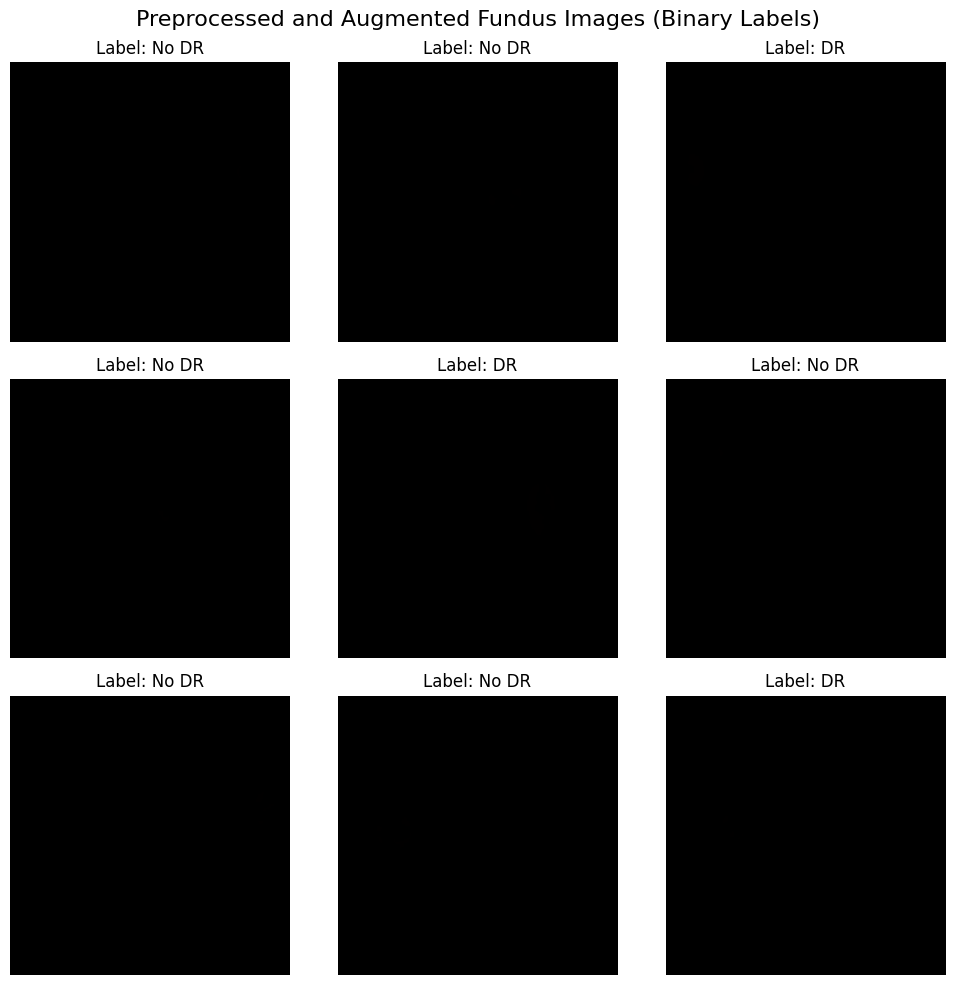

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get a batch of images and labels from CustomDataGenerator
images, labels = train_generator.__getitem__(0)  # First batch

# Convert to numpy if needed
if isinstance(images, tf.Tensor):
    images = images.numpy()
if isinstance(labels, tf.Tensor):
    labels = labels.numpy()

# Ensure labels are 1D for display
labels = labels.squeeze()

# Plot the first 9 images with binary labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Convert float to uint8 if needed
    label_text = "DR" if int(labels[i]) == 1 else "No DR"
    plt.title(f"Label: {label_text}")
    plt.axis("off")

plt.suptitle("Preprocessed and Augmented Fundus Images (Binary Labels)", fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [16]:
!nvidia-smi

Fri Jun 27 10:23:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             31W /  250W |     513MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to stop training if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [18]:
# Print dataset sizes
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total_size = train_size + val_size + test_size

# Compute split percentages
train_ratio = train_size / total_size * 100
val_ratio = val_size / total_size * 100
test_ratio = test_size / total_size * 100

# Print the results
print(f"Dataset Split:")
print(f"Training Set: {train_size} images ({train_ratio:.2f}%)")
print(f"Validation Set: {val_size} images ({val_ratio:.2f}%)")
print(f"Test Set: {test_size} images ({test_ratio:.2f}%)")
print(f"Total Images: {total_size}")


Dataset Split:
Training Set: 2930 images (80.01%)
Validation Set: 366 images (9.99%)
Test Set: 366 images (9.99%)
Total Images: 3662


In [19]:
history = model.fit(
    train_generator,
    epochs=10,  # Feature extraction phase
    validation_data=val_generator,
    #class_weight=class_weight_dict,  # Add computed class weights
    callbacks=[early_stopping]  # Prevent overfitting
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 529s 5s/step - accuracy: 0.7922 - loss: 0.4262 - precision: 0.7890 - recall: 0.7940 - val_accuracy: 0.9460 - val_loss: 0.1482 - val_precision: 0.9323 - val_recall: 0.9676
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.9465 - loss: 0.1644 - precision: 0.9572 - recall: 0.9365 - val_accuracy: 0.9744 - val_loss: 0.1147 - val_precision: 0.9783 - val_recall: 0.9730
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 471s 5s/step - accuracy: 0.9538 - loss: 0.1551 - precision: 0.9613 - recall: 0.9468 - val_accuracy: 0.9716 - val_loss: 0.0982 - val_precision: 0.9944 - val_recall: 0.9514
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.9569 - loss: 0.1211 - precision: 0.9642 - recall: 0.9483 - val_accuracy: 0.9773 - val_loss: 0.0983 - val_precision: 0.9890 - val_recall: 0.9676
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 472s 5s/step - accuracy: 0.9555 - loss: 0.1364 - precision: 0.9667 - recall: 0.9437 - val_accuracy: 0.9801 - val_loss: 0.0819 - val_preci

In [20]:
# Unfreeze the last 50 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
fine_tune_epochs = 5
total_epochs = 10 + fine_tune_epochs

history_finetune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=10,  # resume from epoch 10
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 11/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.8955 - loss: 0.2644 - val_accuracy: 0.9716 - val_loss: 0.0824
Epoch 12/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.9656 - loss: 0.0988 - val_accuracy: 0.9801 - val_loss: 0.0602
Epoch 13/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.9617 - loss: 0.1004 - val_accuracy: 0.9830 - val_loss: 0.0664
Epoch 14/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.9627 - loss: 0.1057 - val_accuracy: 0.9830 - val_loss: 0.0619
Epoch 15/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.9583 - loss: 0.1024 - val_accuracy: 0.9830 - val_loss: 0.0583


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Step 1: Evaluate model on the test set
results = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Step 2: Print each metric name and value
print("\nTest Set Evaluation Metrics:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Step 3: Get predicted probabilities on test set
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Step 4: Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Step 5: Extract true binary labels from test DataFrame
y_true = test_df['binary_label'].values

# Step 6: Trim to match length if needed (safety check)
if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]
    y_pred_probs = y_pred_probs[:len(y_true)]
elif len(y_pred) < len(y_true):
    y_true = y_true[:len(y_pred)]

# Step 7: Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

# Confusion matrix and specificity
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Step 8: Display metrics
print("\n🔍 Detailed Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

print("\n📉 Confusion Matrix:")
print(cm)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9792 - loss: 0.0747

Test Set Evaluation Metrics:
loss: 0.0837
compile_metrics: 0.9744
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step

🔍 Detailed Metrics:
Accuracy: 0.9744
Precision: 0.9809
Recall (Sensitivity): 0.9625
Specificity: 0.9844
F1 Score: 0.9716
AUC Score: 0.9952

📉 Confusion Matrix:
[[189   3]
 [  6 154]]


In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No DR", "DR"]))


Confusion Matrix:
[[189   3]
 [  6 154]]

Classification Report:
              precision    recall  f1-score   support

       No DR       0.97      0.98      0.98       192
          DR       0.98      0.96      0.97       160

    accuracy                           0.97       352
   macro avg       0.98      0.97      0.97       352
weighted avg       0.97      0.97      0.97       352




ROC AUC Score: 0.9952


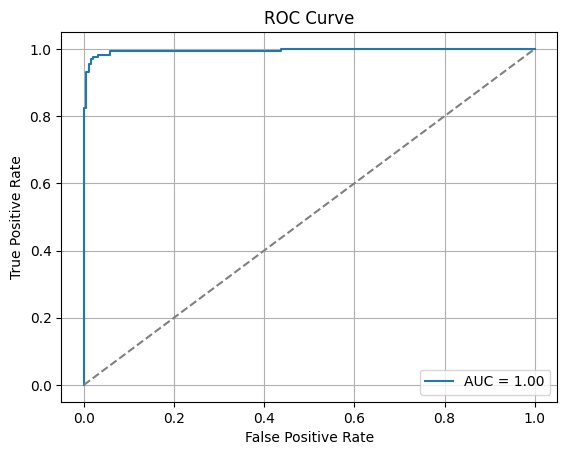

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# AUC Score
auc = roc_auc_score(y_true, y_pred_probs)
print(f"\nROC AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Get true binary labels from test set
y_true = test_df['binary_label'].values

# Predict probabilities
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert probabilities to binary class predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Ensure y_true matches the prediction length
if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]
    y_pred_probs = y_pred_probs[:len(y_true)]
elif len(y_pred) < len(y_true):
    y_true = y_true[:len(y_pred)]

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall (Sensitivity), F1
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# ROC AUC
auc = roc_auc_score(y_true, y_pred_probs)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

print("\nConfusion Matrix:")
print(cm)


11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step
Accuracy: 0.9773
Precision: 0.9750
Recall (Sensitivity): 0.9750
Specificity: 0.9792
F1 Score: 0.9750
AUC Score: 0.9949

Confusion Matrix:
[[188   4]
 [  4 156]]


## Evaluation Metrics Explanation

| **Metric**        | **Meaning** |
|------------------|------------------------------------------------|
| **Accuracy**     | Overall correctness of the model |
| **Precision**    | How many predicted positives were correct? |
| **Sensitivity (Recall)** | How many actual positives were correctly predicted? |
| **F1-Score**     | Balance between Precision & Recall |
| **Specificity**  | How well does the model avoid false positives? |
| **AUC (Area Under Curve)** | How well does the model differentiate between classes? |
